# Exercise: Energy System Model 2
Fabian Schmid | Institut für Energietechnik | FG EVUR | Berlin



## Agenda:
- Scenario development
- Input data
- Create oemof model
- Optimize oemof model
- Access and store results
- Plotting of results

## Scenario development
#### Process of energy system modeling

<img src="jupyter_pics/process_of_energy_system_modeling.png" width="500">


### Real problem with research question
#### Research question:
- Is it possible to supply Schleswig Holstein with 100% renewable energy?
    - We consider the state electricty and heat demand
- What is the optimal energy generation mix?
- Are available areas and resources sufficient to cover the energy demand?


**Basic assumptions**    
- Electricity and heat demand is given as timeseries data
- Excess electricity and heat can be feed-in to an electricity and heat grid without any feed-in tariffs
- Electricty and heat import is not possible, the state energy demand shall be covered by internal renewable ressources! 

<p>&nbsp;</p>

- **Possible components:**
    - Onshore wind turbines
    - Offshore wind turbines
    - PV
    - Hydro run of river (RoR) plants
    - Biomass - Combined Heat and power (CHP) plants 
    - Heat Pumps (HP)
    
- **Possible storage components:**
    - Battery storage
    - Hydrogen storage
    - Adiabatic Compressed Air Energy Storage (ACAES)
    - Thermal storage


#### Energy system to be analyzed

<img src="jupyter_pics/Icons_EnergySystem_exercise2.PNG" width="800">


#### Energy system model its inputs and outputs

<img src="jupyter_pics/overview_model_setup.PNG" width="650">


**Model selection**
- Oemof framework for LP optimization problems with a single-layer design and dispatch optimization
- Integrated energy model with different energy hubs/buses for the representation of electricity and heat demand 
- Linear component definitions with hourly timestep and one year timeframe for regional pre-feasibility analysis 
- Economic assessment with minimization of total system costs


<img src="jupyter_pics/model_catego.PNG" width="500">



## Input data 

- All input data is defined in a excel file called 'input_data_exercise2.xls' with 4 sheets 'timeseries', 'capacity', 'tech', 'costs'
    - Open this excel file, you can find it under folder 'data'
  
**It incudes following data, all specific to Schleswig Holstein**
  
*Data sources can be found in this paper: Maruf_A Novel Method for Analyzing Highly Renewable and Sector Coupled Energy Systems_Schleswig Holstein_2021*
  
- **Meteorological, general and energy consumption data**
    - Timeseries of **normalized electricty demand**
        - Open Power System data platform
        - https://data.open-power-system-data.org/time_series/ 
        - https://arxiv.org/pdf/1812.10405.pdf
            - Profiles downscaled based on population to represent Schleswig Holstein’s hourly demand profiles
            
    - Timeseries of **normalized space heat and hot water demand**            
        - Open Power System data platform - When2Heat Project
        - https://data.open-power-system-data.org/when2heat/2019-08-06
            - Profiles downscaled based on population to represent Schleswig Holstein’s hourly demand profiles
            
    - Timeseries of **capacity factors of onshore/offshore wind, PV** 
        - https://www.renewables.ninja/
        - Scientific background of renewable.ninja: https://www.sciencedirect.com/science/article/pii/S0360544216311744?via%3Dihub
        - Scientific background of renewable.ninja: https://www.sciencedirect.com/science/article/pii/S0360544216311811?via%3Dihub
            - Wind onshore and PV capacity factors represents current profile of Schleswig Holstein
            - Wind offshore represents off shore capacity factors of Germany
            
    - Timeseries of **normalized run of river plant power output**
        - Dispa-SET toolkit - https://github.com/energy-modelling-toolkit/Dispa-SET
            - Scaled inflow profile

<img src="jupyter_pics/ex2_input_timeseries.PNG" width="700">


- Further data on Schleswig Holstein is defined:
    - **Annual electricty, space and hot water heat demand** to scale demand timeseries
    - **Existing plant capacity** of onshore/offshore wind, PV, hydro run of river and Biomass CHP
    - **Available potential for plant expansion**, of
        - Onshore/offshore wind, PV, RoR, CHP, HP and all storages
            - *Energy storages capacities are defined as storage energy and storage power*
    - **Biomass ressource availablility**
        - Total biomass ressource availability represents 6.068 TWh, for this exercise we assume that only 50% of this availability will be exploited, which means 3.034 TWh biomass potential.

<img src="jupyter_pics/ex2_input_capacities.PNG" width="650">

- **System technical data** (its meaning and usage will be explained in detail later)
    - Energy loss, efficiency and charge/discharge hours of storage technologies, CHP and heat pump
        - Heat pump efficeincy represents mean annual Coefficient of Performance

<img src="jupyter_pics/ex2_input_tech.PNG" width="600">


    

- **Economic data** for capacity costs and marginal costs determination of all technologies
    - capital expenditure (capex), weighted average cost of capital (wacc), fixed operation costs (fom), volatile operation costs (vom)
          
<img src="jupyter_pics/costs_calculation.PNG" width="650">


<img src="jupyter_pics/ex2_input_costs.PNG" width="550">

 ### Start energy system model  
- Load needed libaries


### Read input data 

- Use pandas.read_excel()function to read excel file with input data, which is saved in 'input_data_exercise2.xls' in folder data
    - Read each excel sheet in a separat DataFrame, called timeseries, capacities, tech and costs
- Define logger (for better overview of simulation process)

In [1]:
# Import libaries
import pandas as pd

#%% Read input data
# Input Data Reading
timeseries = pd.read_excel('../data/input_data_assignment2.xls', 
                           sheet_name='timeseries', 
                           index_col=[0], 
                           parse_dates=True)

# Add timestep (oemof model needs time increment)
timeseries.index.freq = '1H'

capacities = pd.read_excel('../data/input_data_assignment2.xls', 
                           sheet_name='capacity', 
                           index_col=[0], 
                           parse_dates=True)
tech = pd.read_excel('../data/input_data_assignment2.xls', 
                           sheet_name='tech', 
                           index_col=[0], 
                           parse_dates=True)
costs = pd.read_excel('../data/input_data_assignment2.xls', 
                           sheet_name='costs', 
                           index_col=[0], 
                           parse_dates=True)



array([<AxesSubplot:xlabel='timeindex'>, <AxesSubplot:xlabel='timeindex'>,
       <AxesSubplot:xlabel='timeindex'>, <AxesSubplot:xlabel='timeindex'>,
       <AxesSubplot:xlabel='timeindex'>, <AxesSubplot:xlabel='timeindex'>,
       <AxesSubplot:xlabel='timeindex'>], dtype=object)

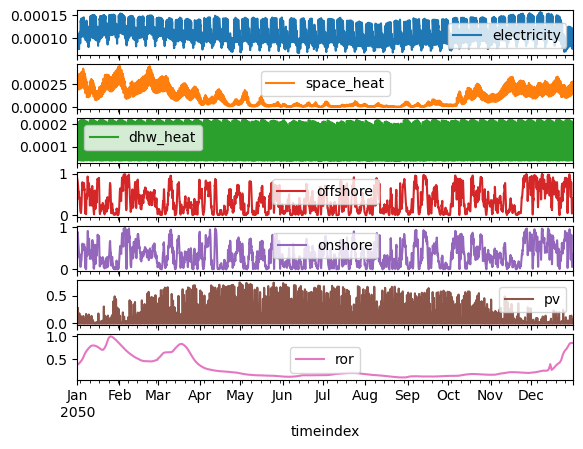

In [2]:
# Plot timeseries data
timeseries.plot(subplots=True)

## Create oemof model
- **Electricty, Space and HDW heat demand**

- **Possible components:**
    - Onshore wind turbines
    - Offshore wind turbines
    - PV
    - Hydro run of river (RoR) plants
    - Biomass - Combined Heat and power (CHP) plants 
    - Heat Pumps (HP)
    
- **Possible storage components:**
    - Battery storage
    - Hydrogen storage
    - Adiabatic Compressed Air Energy Storage (ACAES)
    - Thermal storage
    
**Task:**
- Work in groups and create a oemof graphical energy system model which specifies the most basic oemof classes
    - Components (Sink, Source, Transformer) and Bus


The correct oemof energysystem looks like this


![energy system model oemof](jupyter_pics/oemof_EnergySystem_exercise2.png) 

### Initialize energysystem
- Initialize your energy system called energysystem with a DatetimeIndex

In [3]:
# Load libaries
from oemof import solph
from oemof.tools import economics

import matplotlib.pyplot as plt
from collections import OrderedDict

#%% Initialize the energy system and read/calculate necessary parameters
energysystem = solph.EnergySystem(timeindex=timeseries.index)

### Create oemof bus

- Electricity bus
- Heat bus
- Biomass bus

In [4]:
#%% Create oemof Buses

# create electricity bus
bus_electricity = solph.Bus(label='bus_electricity_l')
# create heat bus
bus_heat = solph.Bus(label='bus_heat_l')
# create biomass bus
bus_biomass = solph.Bus(label='bus_biomass_l')

# add buses to energy model
energysystem.add(bus_electricity, bus_heat, bus_biomass)

### Create oemof sinks

- Electricity demand
- Electricity excess
- Space heat demand
- Hot Drinking water heat demand
- Heat excess

In [5]:
#%% Create oemof Sinks

# create excess component for the electricity bus to allow overproduction
electricity_excess = solph.Sink(label='electricty_excess_l', 
                                inputs={bus_electricity: solph.Flow()})

# create simple sink object representing the electrical demand
electricity_demand = solph.Sink(label='electricity_demand_l',
                                inputs={bus_electricity: solph.Flow(
                                        fix=timeseries['electricity'], 
                                        nominal_value=capacities['electricity']['amount'])})

# create excess component for the heat bus to allow overproduction
heat_excess = solph.Sink(label='heat_excess_l', 
                         inputs={bus_heat: solph.Flow()})

# create simple sink object representing the heat demand (space heat and hot water demand)
heat_space_demand = solph.Sink(label='heat_space_demand_l',
                               inputs={bus_heat: solph.Flow(
                                       fix=timeseries['space_heat'], 
                                       nominal_value=capacities['space_heat']['amount'])})

heat_dhw_demand = solph.Sink(label='heat_dhw_demand_l',
                             inputs={bus_heat: solph.Flow(
                                     fix=timeseries['dhw_heat'], 
                                     nominal_value=capacities['dhw_heat']['amount'])})

### Economic parameter definition

- Dispatch and sizing optimization aim to minimize total system costs
- Therefore for all components capacity costs for new installations and marginal costs for dispatch need to be defined 

![economic_objective](jupyter_pics/economic_objective_function.PNG)

*In our model we use MW and MWh as basic power/energy units!*
![economic_parameter](jupyter_pics/economic_parameter.PNG)

- For this purpose the **Investment mode** will be integrated!
    - https://oemof-solph.readthedocs.io/en/latest/usage.html#using-the-investment-mode

#### Capacity cost calculation
- Calculation of capex annuity 
- Summation of capex annity with fixed opex
    - capex costs are defined in €/MW or €/MWh
    - fixed opex costs are defined in €/MW/a or €/MWh/a

for all components with possible new installations 


- For electricty storage a distinction is made between:
    - investment in storage energy capacity [MWh] (e.g. Pumped hydro storage bassin)
    - investment in storage power capacity [MW] (e.g. Pumped hydro storage pump/turbine)


In [6]:
#%% Economic caluclation (for dispatch/sizing optimization) 

## Capital costs [€/MW(h)]
# Annuities [€/MW(h)/a]
a_onshore = economics.annuity(capex=costs['onshore']['capex'], 
                              n=costs['onshore']['lifetime'],
                              wacc=costs['onshore']['wacc'])
a_offshore = economics.annuity(capex=costs['offshore']['capex'], 
                               n=costs['offshore']['lifetime'],
                               wacc=costs['offshore']['wacc'])
a_pv = economics.annuity(capex=costs['pv']['capex'], 
                         n=costs['pv']['lifetime'],
                         wacc=costs['pv']['wacc'])
a_ror = economics.annuity(capex=costs['ror']['capex'], 
                          n=costs['ror']['lifetime'],
                          wacc=costs['ror']['wacc'])

a_chp = economics.annuity(capex=costs['chp']['capex'], 
                            n=costs['chp']['lifetime'],
                            wacc=costs['chp']['wacc'])
a_hp = economics.annuity(capex=costs['hp']['capex'], 
                           n=costs['hp']['lifetime'],
                           wacc=costs['hp']['wacc'])

a_battery_energy = economics.annuity(capex=costs['battery']['capex_energy'], 
                                     n=costs['battery']['lifetime'],
                                     wacc=costs['battery']['wacc'])
a_battery = economics.annuity(capex=costs['battery']['capex'], 
                              n=costs['battery']['lifetime'],
                              wacc=costs['battery']['wacc'])
a_hydrogen_energy = economics.annuity(capex=costs['hydrogen']['capex_energy'], 
                                      n=costs['hydrogen']['lifetime'],
                                      wacc=costs['hydrogen']['wacc'])
a_hydrogen = economics.annuity(capex=costs['hydrogen']['capex'], 
                               n=costs['hydrogen']['lifetime'],
                               wacc=costs['hydrogen']['wacc'])
a_acaes_energy = economics.annuity(capex=costs['acaes']['capex_energy'], 
                                     n=costs['acaes']['lifetime'],
                                     wacc=costs['acaes']['wacc'])
a_acaes = economics.annuity(capex=costs['acaes']['capex'], 
                              n=costs['acaes']['lifetime'],
                              wacc=costs['acaes']['wacc'])
a_tes_energy = economics.annuity(capex=costs['tes']['capex_energy'], 
                                   n=costs['tes']['lifetime'],
                                       wacc=costs['tes']['wacc'])


In [7]:
# Capital costs sum of annuities and fixed opex [€/MW(h)/a]
cc_onshore = (a_onshore + costs['onshore']['fom'])
cc_offshore = (a_offshore + costs['offshore']['fom'])
cc_pv = (a_pv + costs['pv']['fom'])
cc_ror = (a_ror + costs['ror']['fom'])

cc_chp = (a_chp + costs['chp']['fom'])
cc_hp = (a_hp + costs['hp']['fom'])

cc_battery_energy = (a_battery_energy + costs['battery']['fom'])
cc_battery = (a_battery)
cc_hydrogen_energy = (a_hydrogen_energy + costs['hydrogen']['fom'])
cc_hydrogen = (a_hydrogen)
cc_acaes_energy = (a_acaes_energy + costs['acaes']['fom'])
cc_acaes = (a_acaes)
cc_tes_energy = (a_tes_energy + costs['tes']['fom'])

#### Marginal cost calculation
- Definition of variable opex
    - variable opex costs are defined in €/MWh/a
    
for all components with operation costs, due to optimal dispatch

In [8]:
## Marginal costs [€/MWh/a]
mc_onshore = costs['onshore']['vom']
mc_offshore = costs['offshore']['vom']
mc_pv = costs['pv']['vom']
mc_ror = costs['ror']['vom']

mc_chp = (costs['chp']['vom'])
mc_hp = costs['hp']['vom']

mc_battery = costs['battery']['vom']
mc_hydrogen = costs['hydrogen']['vom']
mc_acaes = costs['acaes']['vom']
mc_tes = costs['tes']['vom']

### Create oemof sources

- A Source has **1 output flow**.
    - https://oemof-solph.readthedocs.io/en/latest/usage.html#source-basic
    
#### Definition of source objects with investent mode
- Onshore wind turbine
- Offshore wind turbine
- PV
- RoR
- Biomass ressource with investment mode, as only biomass ressource availability is managed with this source
    
**Further considerations:**
- Marginal costs are connected to the produced energy of the source and therefore need to be connected to the source Flow() (variable_costs)
- Annual capital costs are connected to the new investments and can be defined as ep_costs in the Investment mode
- Existing (existing) and the potential of additional (maximum) investments can be defined in the Investment mode
    - https://oemof-solph.readthedocs.io/en/latest/usage.html#using-the-investment-mode

In [9]:
#%%Create oemof Sources

# create fixed source object representing wind power plants offshore
wind_offshore = solph.Source(label='wind_offshore_l',
                             outputs={bus_electricity: solph.Flow(   
                                     fix=timeseries['offshore'], 
                                     variable_costs=mc_offshore,
                                     investment=solph.Investment(
                                                ep_costs=cc_offshore,
                                                maximum=capacities['offshore']['capacity_potential'],
                                                existing=capacities['offshore']['capacity_existing']))
                                    },)

# create fixed source object representing wind power plants onshore
wind_onshore = solph.Source(label='wind_onshore_l',
                            outputs={bus_electricity: solph.Flow(
                                    fix=timeseries['onshore'], 
                                    variable_costs=mc_onshore,
                                    investment=solph.Investment(
                                               ep_costs=cc_onshore,
                                               maximum=capacities['onshore']['capacity_potential'],
                                               existing=capacities['onshore']['capacity_existing']))
                                    },)

# create fixed source object representing pv power plants
pv = solph.Source(label='pv_l',
                  outputs={bus_electricity: solph.Flow(
                           fix=timeseries['pv'], 
                           variable_costs=mc_pv,
                           investment=solph.Investment(
                                      ep_costs=cc_pv,
                                      maximum=capacities['pv']['capacity_potential'],
                                      existing=capacities['pv']['capacity_existing']))
                           },)

# create fixed source object representing hydro run of river plant
ror = solph.Source(label='ror_l',
                   outputs={bus_electricity: solph.Flow(
                            fix=timeseries['ror'], 
                            variable_costs=mc_ror,
                            investment=solph.Investment(
                                       ep_costs=cc_ror,
                                       maximum=capacities['ror']['capacity_potential'],
                                       existing=capacities['ror']['capacity_existing']))
                            },)

# create fixed source object representing biomass ressource
biomass = solph.Source(label='biomass_l',
                       outputs={bus_biomass: solph.Flow(
                               nominal_value=capacities['biomass']['capacity_potential'],
                               summed_max=1)
                               },)
                                   	

### Create oemof GenericStorage

- The GenericStorage is designed for **1 input and 1 output**.
    - https://oemof-solph.readthedocs.io/en/latest/usage.html#genericstorage-component
    
#### Definition of GenericStorage objects with investent mode
- Battery
- Hydrogen
- ACAES
- Thermal energy storage (only capital costs for storage energy occur)

**Further considerations:**
- As the GenericStorage Storage component is associated with costs the **Investment mode** needs to be integrated!
    - https://oemof-solph.readthedocs.io/en/latest/usage.html#using-the-investment-mode

- Marginal costs are connected to the charged/discharged energy of the GenericStorage and therefore need to be connected to the Flow() (variable_costs)

- Annual capital costs are connected to the new investments in GenericStorage **Power capacity and Energy storage capacity**
    - Power capacity Investment is integrated in the Flow()
    - Energy storage capacity Investment is integrated as in Source objects
    - Use the correct capital costs for energy and power capacity
        - Be aware that power capacity investment cost are the sum for charge and discharge investment and therefore need to be integrated only in inputs Flow()
- Existing (existing) and the potential of additional (maximum) investments need to be defined

- Be sure to define energy loss, efficiency correctly  
    
    
**The definition of maximum C-Rate with parameter max_hours**
- In order to couple in and output flows (storage power) with storage energy capacity (for battery we speak of: C-Rate) the parameters:
    - ‘invest_relation_output_capacity‘ and ‘invest_relation_input_capacity‘ need to be defined with the storage C-Rate
    - For every storage component the parameter max_hours is defined as the number of hours, which are needed to (dis)charge the storage to its maximum SoC with the maximum storage (dis)charge power
        - For the case of the battery this is 6.5h, which means that in 6.5h the battery can be fully (dis)charged
        - **Definition: C-rate = 1/max_hours**, for the battery C-Rate = 1/6.5h = 0.1538 1/h

    - With the same maximum charge and discharge C-Rate it is guaranteed that the investment in storage power for input and output has the same relation to the storage energy!

In [10]:
#%% Create oemof Storages

# create storage object representing a battery
battery = solph.components.GenericStorage(label='battery_l',
                                          inputs={bus_electricity: solph.Flow(
                                                  investment=solph.Investment(
                                                             ep_costs=cc_battery,
                                                             maximum=capacities['battery']['storage_power_potential']),
                                                  variable_costs=mc_battery)},
                                          outputs={bus_electricity: solph.Flow()},
                                          loss_rate=tech['battery']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech['battery']['max_hours'],
                                          invest_relation_output_capacity=1/tech['battery']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech['battery']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_battery_energy,
                                                     maximum=capacities['battery']['capacity_potential']),)

# create storage object representing a hydrogen
hydrogen = solph.components.GenericStorage(label='hydrogen_l',
                                          inputs={bus_electricity: solph.Flow(
                                                  investment=solph.Investment(
                                                             ep_costs=cc_hydrogen,
                                                             maximum=capacities['hydrogen']['storage_power_potential']),
                                                  variable_costs=mc_hydrogen)},
                                          outputs={bus_electricity: solph.Flow()},
                                          loss_rate=tech['hydrogen']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech['hydrogen']['max_hours'],
                                          invest_relation_output_capacity=1/tech['hydrogen']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech['hydrogen']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_hydrogen_energy,
                                                     maximum=capacities['hydrogen']['capacity_potential']),)

# create storage object representing a adiabatic compressed air energy storage (ACAES)
acaes = solph.components.GenericStorage(label='acaes_l',
                                          inputs={bus_electricity: solph.Flow(
                                                  investment=solph.Investment(
                                                             ep_costs=cc_acaes,
                                                             maximum=capacities['acaes']['storage_power_potential']),
                                                  variable_costs=mc_acaes)},
                                          outputs={bus_electricity: solph.Flow()},
                                          loss_rate=tech['acaes']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech['acaes']['max_hours'],
                                          invest_relation_output_capacity=1/tech['acaes']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech['acaes']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_acaes_energy,
                                                     maximum=capacities['acaes']['capacity_potential']),)

# create storage object representing a battery
tes = solph.components.GenericStorage(label='tes_l',
                                          inputs={bus_heat: solph.Flow(
                                                  investment=solph.Investment(
                                                             maximum=capacities['tes']['storage_power_potential']),
                                                  variable_costs=mc_tes)},
                                          outputs={bus_heat: solph.Flow()},
                                          loss_rate=tech['tes']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech['tes']['max_hours'],
                                          invest_relation_output_capacity=1/tech['tes']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech['tes']['efficiency'],
                                          investment=solph.Investment(
                                                     ep_costs=cc_tes_energy,
                                                     maximum=capacities['tes']['capacity_potential']),)

### Create oemof Transformer

- The Transformer is designed for **multiple inputs and multiple outputs**.
    - https://oemof-solph.readthedocs.io/en/latest/usage.html#transformer-basic
    
#### Definition of Transformer objects with investent mode
- Biomass - Combined Heat and Power plant (CHP)
- Heat Pump

**Further considerations:**
- CHP
    - Marginal costs of biomass need to be considered in Transformer input flow()
    - Capital costs of CHP investment are defined in €/MW_electric and therefore need to be considered in the CHP electric output flow()
    - Define electric and thermal efficiency
    
- Heat Pump
    - Capital costs of HP investment are defined in €/MW_thermal and therefore need to be considered in the HP thermal output flow()
    - Be aware weather you need to use heat pump COP efficiency or the reciprocal in case you use electricty or heat bus for the conversion_factor definition 

In [11]:
#%% Create oemof Transormers

# create transformer object representing CHP plants
chp = solph.Transformer(label='chp_l',
                        inputs={bus_biomass: solph.Flow(
                                    variable_costs=mc_chp)},
                        outputs={bus_electricity: solph.Flow(
                                    investment=solph.Investment(
                                               ep_costs=cc_chp,
                                               existing=capacities['chp']['capacity_existing'])),
                                 bus_heat: solph.Flow()},
                        conversion_factors={bus_electricity: tech['chp']['electric_efficiency'],
                                            bus_heat: tech['chp']['thermal_efficiency']},
                        )

# create transformer object representing heat pumps
hp = solph.Transformer(label='hp_l',
                       inputs={bus_electricity: solph.Flow()},
                       outputs={bus_heat: solph.Flow(
                                investment=solph.Investment(
                                           ep_costs=cc_hp),
                                variable_costs=mc_hp)},
                       conversion_factors={bus_electricity: 1/tech['hp']['efficiency']},
                       )

- **All Sink, Source and GenericStorage objects created need to be added to the EnergySystem**

In [12]:
#%% Add all components to the energysystem
energysystem.add(electricity_excess, electricity_demand,
                 heat_excess, heat_space_demand, heat_dhw_demand,
                 wind_offshore, wind_onshore, pv, ror, biomass,
                 battery, hydrogen, acaes, tes, 
                 hp, chp)

## Optimize oemof model

- Define optimization model via solph.Model()
- Solve the optimization problem with the definition of the used solver and call attribute model.solve()
    - use cbc solver

In [13]:
#%% Optimise the energy system

# initialise the operational model
om = solph.Model(energysystem)

# if tee_switch is true solver messages will be displayed
om.solve(solver='cbc')


{'Problem': [{'Name': 'unknown', 'Lower bound': 3411556517.0, 'Upper bound': 3411556517.0, 'Number of objectives': 1, 'Number of constraints': 245298, 'Number of variables': 210263, 'Number of nonzeros': 35047, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 407.74, 'Wallclock time': 409.55, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': None, 'Number of created subproblems': None}, 'Black box': {'Number of iterations': 95700}}, 'Error rc': 0, 'Time': 409.63638615608215}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

## Access and store results
- Optimization results can be stored, to be access savely in a later step (*optional*).
- Collecting results can be done with the help of the processing module. 


#### solph.processing.results() function:
- Use solph.processing.results() function
    - Documentation: https://oemof-solph.readthedocs.io/en/latest/usage.html#results-collect-results-label  

In [14]:
#Extract main results save results to dump (optional)
energysystem.results['main'] = solph.processing.results(om)
energysystem.dump('../results/dumps',
                  filename='model.oemof')

'Attributes dumped to: ../results/dumps/model.oemof'

#### solph.processing.results() function:
- Use solph.processing.results() function
    - Documentation: https://oemof-solph.readthedocs.io/en/latest/usage.html#results-collect-results-label
- Gives back the results as a python dictionary holding **pandas Series for scalar values** and **pandas DataFrames for all nodes and flows** between them.
- You can directly extract the data in the dictionary by using these keys, where “node” is the name of the object you want to address. 
    - you can use specified *component_label* to access the component data - '*component_label*' (use quotes)
    - you can use specified *component_parameter_name* to access the component data - *component_parameter_name*
- The keys of the results dictionary are tuples containing two nodes. Since flows have a starting node and an ending node

#### solph.views.node() function:
- An **easy access** of the results can be done via oemof.views.node()
    - https://oemof-solph.readthedocs.io/en/latest/usage.html#results-easy-access-label
- Easily one specific DataFrame can be extracted from us with the definition of the defined key.

In [15]:
#%% Extract results 

# Extract results dict
results = solph.processing.results(om)

# Extract component results
results_wind_offshore = solph.views.node(results, 'wind_offshore_l')
results_wind_onshore = solph.views.node(results, 'wind_onshore_l')
results_pv = solph.views.node(results, 'pv_l')
results_ror = solph.views.node(results, 'ror_l')

results_biomass = solph.views.node(results, 'bus_biomass_l')
results_chp = solph.views.node(results, 'chp_l')
results_hp = solph.views.node(results, 'hp_l')

results_battery = solph.views.node(results, 'battery_l')
results_hydrogen = solph.views.node(results, 'hydrogen_l')
results_acaes = solph.views.node(results, 'acaes_l')
results_tes = solph.views.node(results, 'tes_l')

# Extract bus results
results_electricity_bus = solph.views.node(results, 'bus_electricity_l')
results_heat_bus = solph.views.node(results, 'bus_heat_l')
results_biomass_bus = solph.views.node(results, 'bus_biomass_l')

6771.0

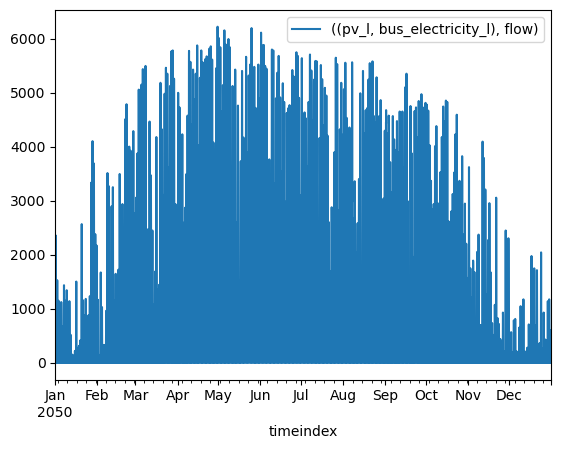

In [16]:
results_pv
results_pv['sequences'].plot()
results_pv['scalars'].iloc[0]

### Extract installed capacities of all components
- Different aproach to extract data
- Extract and store it an Orderdict (orders entries according to definition in contrast to random dict)
- Transfer Orderdict to DataFrame and transpose it for better readability

In [17]:
#%% Results: Installed capacities
# Define capacity results dict
results_capacity = OrderedDict()

# installed capacity of wind power plant in MW
results_capacity['wind_onshore_invest_MW'] = results[(wind_onshore, bus_electricity)]['scalars']['invest']
# installed capacity of wind power plant in MW
results_capacity['wind_offshore_invest_MW'] = results[(wind_offshore, bus_electricity)]['scalars']['invest']
# installed capacity of pv power plant in MW
results_capacity['pv_invest_MW'] = results[(pv, bus_electricity)]['scalars']['invest']
# installed capacity of pv power plant in MW
results_capacity['ror_invest_MW'] = results[(ror, bus_electricity)]['scalars']['invest']

# installed capacity of chp plant in MW
results_capacity['chp_invest_MW_el'] = results[(chp, bus_electricity)]['scalars']['invest']
# installed capacity of heat pump in MW
results_capacity['hp_invest_MW_th'] = results[(hp, bus_heat)]['scalars']['invest']

# installed capacity of battery storage in MWh
results_capacity['battery_invest_MWh'] = results[(battery, None)]['scalars']['invest']
# installed power capacity of battery storage in MW
results_capacity['battery_invest_MW_ch'] = results[(bus_electricity, battery)]['scalars']['invest']
results_capacity['battery_invest_MW_dch'] = results[(battery, bus_electricity)]['scalars']['invest']

# installed capacity of hydrogen storage in MWh
results_capacity['hydrogen_invest_MWh'] = results[(hydrogen, None)]['scalars']['invest']
# installed power capacity of hydrogen storage in MW
results_capacity['hydrogen_invest_MW_ch'] = results[(bus_electricity, hydrogen)]['scalars']['invest']
results_capacity['hydrogen_invest_MW_dch'] = results[(hydrogen, bus_electricity,)]['scalars']['invest']

# installed capacity of acaes storage in MWh
results_capacity['acaes_invest_MWh'] = results[(acaes, None)]['scalars']['invest']
# installed power capacity of acaes storage in MW
results_capacity['acaes_invest_MW_ch'] = results[(bus_electricity, acaes)]['scalars']['invest']
results_capacity['acaes_invest_MW_dch'] = results[(acaes, bus_electricity)]['scalars']['invest']

# installed capacity of thermal storage in MWh
results_capacity['thermal_storage_invest_MWh'] = results[(tes, None)]['scalars']['invest']
# installed power capacity of thermal storage in MW
results_capacity['thermal_storage_invest_MW_ch'] = results[(bus_heat, tes)]['scalars']['invest']
results_capacity['thermal_storage_invest_MW_dch'] = results[(tes, bus_heat)]['scalars']['invest']

# Transfer dict to DataFRame and transpose for better readybility
results_capacity_df = pd.DataFrame(results_capacity, index=[0]).T
results_capacity_df

,0
wind_onshore_invest_MW,1936.00000
wind_offshore_invest_MW,1211.37650
pv_invest_MW,6771.00000
ror_invest_MW,4.00000
chp_invest_MW_el,994.43687
hp_invest_MW_th,6794.65780
battery_invest_MWh,5388.50000
battery_invest_MW_ch,829.00000
battery_invest_MW_dch,829.00000
hydrogen_invest_MWh,42081.46700


### Interpretation of results
- Invest and sequences
    - The investment mode sums the newly installed capacities to the existig capacities
    - But it returns as a result only the new installed capacities
    - But timeseries in 'sequences' define the timeseries of both existing and newly installed capacities!

### Store summarized results to excel
- Use xlsxwriter to store DataFrames to different sheets in result excel file stored in folder results

In [18]:
#%% Collection of all results and exporting to ecxel file

# Create a Pandas Excel writer using XlsxWriter as the engine.
with pd.ExcelWriter('../results/results_overview.xlsx', engine='xlsxwriter') as writer:  
    
    # Write each dataframe to a different worksheet.
    results_capacity_df.to_excel(writer, sheet_name='capacities')


## Plotting of results

<AxesSubplot:xlabel='timeindex'>

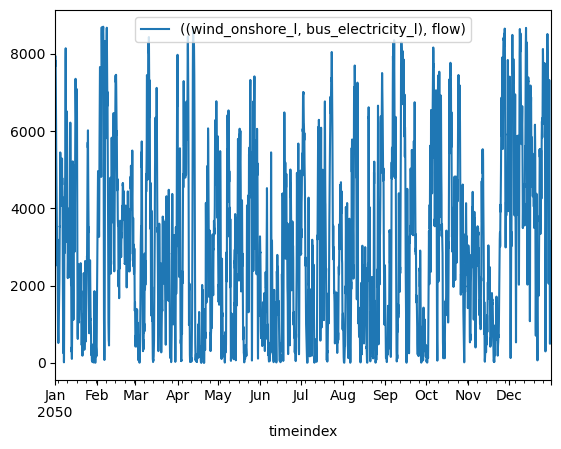

In [19]:
# Exract timeseries result and plot it
wind_onshore_ts = results_wind_onshore['sequences']
wind_onshore_ts.plot()


In [20]:
#%% Extract timeseries results of all components to plot
# Different approach to extract data

results_elec_ts = OrderedDict()
# Extract electricty component timeseries
results_elec_ts['wind_offshore'] = results[(wind_offshore, bus_electricity)]['sequences']['flow']
results_elec_ts['wind_onshore'] = results[(wind_onshore, bus_electricity)]['sequences']['flow'] 
results_elec_ts['pv'] = results[(pv, bus_electricity)]['sequences']['flow']
results_elec_ts['ror'] = results[(ror, bus_electricity)]['sequences']['flow']
results_elec_ts['chp'] = results[(chp, bus_electricity)]['sequences']['flow']

results_elec_ts['elec_demand'] = results[(bus_electricity, electricity_demand)]['sequences']['flow']
results_elec_ts['elec_excess'] = results[(bus_electricity, electricity_excess)]['sequences']['flow']
results_elec_ts

OrderedDict([('wind_offshore',
              timeindex
              2050-01-01 00:00:00+00:00    2607.79880
              2050-01-01 01:00:00+00:00    2589.77260
              2050-01-01 02:00:00+00:00    2524.57760
              2050-01-01 03:00:00+00:00    2499.64130
              2050-01-01 04:00:00+00:00    2463.58880
                                              ...    
              2050-12-31 19:00:00+00:00     657.95846
              2050-12-31 20:00:00+00:00     679.89041
              2050-12-31 21:00:00+00:00     759.50639
              2050-12-31 22:00:00+00:00     917.53660
              2050-12-31 23:00:00+00:00    1198.44580
              Freq: H, Name: flow, Length: 8760, dtype: float64),
             ('wind_onshore',
              timeindex
              2050-01-01 00:00:00+00:00    7772.4
              2050-01-01 01:00:00+00:00    7951.5
              2050-01-01 02:00:00+00:00    7834.5
              2050-01-01 03:00:00+00:00    7713.9
              2050-01-01 04:00:

In [21]:
results_heat_ts = OrderedDict()
# Extract results to plot
results_heat_ts['hp'] = results[(hp, bus_heat)]['sequences']['flow']
results_heat_ts['chp'] = results[(chp, bus_heat)]['sequences']['flow']

results_heat_ts['heat_dhw_demand'] = solph.views.node(results, 'heat_dhw_demand_l')['sequences']
results_heat_ts['heat_space_demand'] = solph.views.node(results, 'heat_space_demand_l')['sequences']
results_heat_ts['heat_excess'] = solph.views.node(results, 'heat_excess_l')['sequences']
results_heat_ts

OrderedDict([('hp',
              timeindex
              2050-01-01 00:00:00+00:00    4813.2656
              2050-01-01 01:00:00+00:00    4879.9004
              2050-01-01 02:00:00+00:00    4984.5824
              2050-01-01 03:00:00+00:00    5212.4813
              2050-01-01 04:00:00+00:00    5798.9656
                                             ...    
              2050-12-31 19:00:00+00:00    4175.8766
              2050-12-31 20:00:00+00:00    4008.9579
              2050-12-31 21:00:00+00:00    3583.6328
              2050-12-31 22:00:00+00:00    3626.6252
              2050-12-31 23:00:00+00:00    2944.8484
              Freq: H, Name: flow, Length: 8760, dtype: float64),
             ('chp',
              timeindex
              2050-01-01 00:00:00+00:00    0.0
              2050-01-01 01:00:00+00:00    0.0
              2050-01-01 02:00:00+00:00    0.0
              2050-01-01 03:00:00+00:00    0.0
              2050-01-01 04:00:00+00:00    0.0
                           

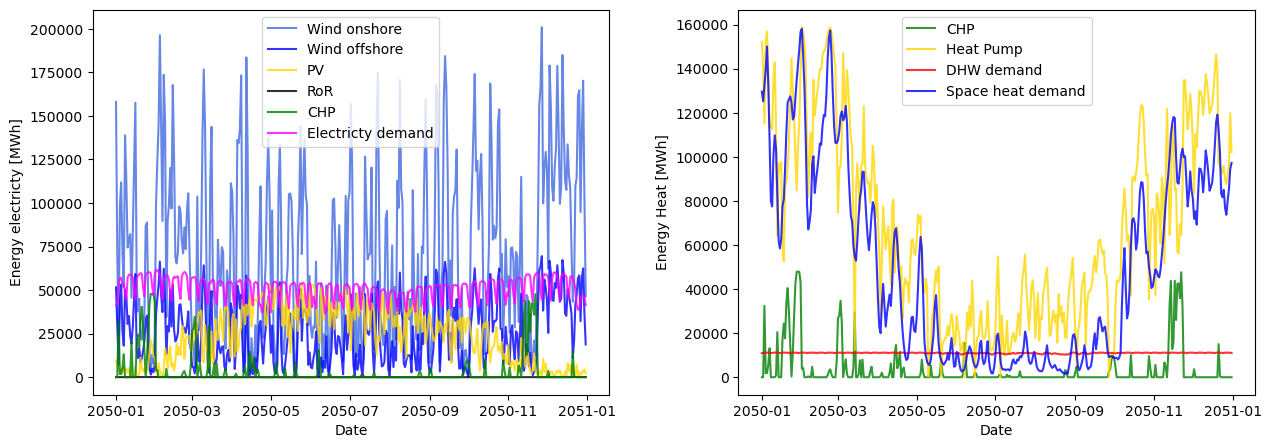

In [22]:
#%% Overview plot

#Resample timestep to 1 day               
freq_sample='D'
set_alpha=0.8

# Inilialize figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5) , sharey=False,sharex=False)
plt.subplots_adjust(wspace=0.25, hspace=0.05)

axes[0].plot(results_elec_ts['wind_onshore'].resample(freq_sample).sum(), alpha=set_alpha, color='royalblue', label='Wind onshore')
axes[0].plot(results_elec_ts['wind_offshore'].resample(freq_sample).sum(), alpha=set_alpha, color='blue', label='Wind offshore')
axes[0].plot(results_elec_ts['pv'].resample(freq_sample).sum(), alpha=set_alpha, color='gold', label='PV')
axes[0].plot(results_elec_ts['ror'].resample(freq_sample).sum(), alpha=set_alpha, color='black', label='RoR')
axes[0].plot(results_elec_ts['chp'].resample(freq_sample).sum(), alpha=set_alpha, color='green', label='CHP')

axes[0].plot(results_elec_ts['elec_demand'].resample(freq_sample).sum(), alpha=set_alpha, color='magenta', label='Electricty demand')
#axes[0].plot(results_elec_ts['elec_excess'].resample(freq_sample).sum(), alpha=set_alpha, color='cyan', label='Electricty excess')

#axes[0].set_ylim(0, 10000)
axes[0].legend()
axes[0].set_ylabel('Energy electricty [MWh]')
axes[0].set_xlabel('Date')

axes[1].plot(results_heat_ts['chp'].resample(freq_sample).sum(), alpha=set_alpha, color='green', label='CHP')
axes[1].plot(results_heat_ts['hp'].resample(freq_sample).sum(), alpha=set_alpha, color='gold', label='Heat Pump')

axes[1].plot(results_heat_ts['heat_dhw_demand'].resample(freq_sample).sum(), alpha=set_alpha, color='red', label='DHW demand')
axes[1].plot(results_heat_ts['heat_space_demand'].resample(freq_sample).sum(), alpha=set_alpha, color='blue', label='Space heat demand')
#axes[1].plot(results_heat_ts['heat_dhw_demand'].resample(freq_sample).sum(), alpha=set_alpha, color='cyan', label='Heat excess')

#axes[1].set_ylim(0, 10000)
axes[1].legend()
axes[1].set_ylabel('Energy Heat [MWh]')
axes[1].set_xlabel('Date')

plt.show()
fig.savefig('../results/analysis_ts_overview.png', dpi=300)

In [23]:
results

{("<oemof.solph.components.generic_storage.GenericStorage: 'acaes_l'>",
  None): {'scalars': variable_name
  init_content        0.0
  invest          12008.5
  Name: 2050-01-01 00:00:00+00:00, dtype: float64,
  'sequences': variable_name              storage_content
  timeindex                                 
  2050-01-01 00:00:00+00:00              0.0
  2050-01-01 01:00:00+00:00              0.0
  2050-01-01 02:00:00+00:00              0.0
  2050-01-01 03:00:00+00:00              0.0
  2050-01-01 04:00:00+00:00              0.0
  ...                                    ...
  2050-12-31 19:00:00+00:00              0.0
  2050-12-31 20:00:00+00:00              0.0
  2050-12-31 21:00:00+00:00              0.0
  2050-12-31 22:00:00+00:00              0.0
  2050-12-31 23:00:00+00:00              0.0
  
  [8760 rows x 1 columns]},
 ("<oemof.solph.components.generic_storage.GenericStorage: 'acaes_l'>",
  "<oemof.solph.network.bus.Bus: 'bus_electricity_l'>"): {'scalars': variable_name
  inve

In [27]:
node_edemand = energysystem.groups['electricity_demand_l']
print(results[(bus_electricity, node_edemand)])

{'scalars': Series([], Name: 2050-01-01 00:00:00+00:00, dtype: float64), 'sequences': variable_name                     flow
timeindex                             
2050-01-01 00:00:00+00:00  1834.310042
2050-01-01 01:00:00+00:00  1772.477211
2050-01-01 02:00:00+00:00  1696.797201
2050-01-01 03:00:00+00:00  1630.284714
2050-01-01 04:00:00+00:00  1591.044650
...                                ...
2050-12-31 19:00:00+00:00  1907.228284
2050-12-31 20:00:00+00:00  1741.253933
2050-12-31 21:00:00+00:00  1687.936543
2050-12-31 22:00:00+00:00  1707.729183
2050-12-31 23:00:00+00:00  1629.287412

[8760 rows x 1 columns]}


In [31]:
flows = [x for x in results.keys() if x[1] is not None]
nodes = [x for x in results.keys() if x[1] is None]
for flow in flows:
    print(flow)
    print(results[flow]['scalars'])
    print(results[flow]['sequences'])


("<oemof.solph.components.generic_storage.GenericStorage: 'acaes_l'>", "<oemof.solph.network.bus.Bus: 'bus_electricity_l'>")
variable_name
invest    1715.5
Name: 2050-01-01 00:00:00+00:00, dtype: float64
variable_name              flow
timeindex                      
2050-01-01 00:00:00+00:00   0.0
2050-01-01 01:00:00+00:00   0.0
2050-01-01 02:00:00+00:00   0.0
2050-01-01 03:00:00+00:00   0.0
2050-01-01 04:00:00+00:00   0.0
...                         ...
2050-12-31 19:00:00+00:00   0.0
2050-12-31 20:00:00+00:00   0.0
2050-12-31 21:00:00+00:00   0.0
2050-12-31 22:00:00+00:00   0.0
2050-12-31 23:00:00+00:00   0.0

[8760 rows x 1 columns]
("<oemof.solph.components.generic_storage.GenericStorage: 'battery_l'>", "<oemof.solph.network.bus.Bus: 'bus_electricity_l'>")
variable_name
invest    829.0
Name: 2050-01-01 00:00:00+00:00, dtype: float64
variable_name                   flow
timeindex                           
2050-01-01 00:00:00+00:00    0.00000
2050-01-01 01:00:00+00:00    0.00000
20

In [36]:
flows_to_elec = [x for x in results.keys() if 'elec_demand' in x[1].label]

AttributeError: 'NoneType' object has no attribute 'label'

In [38]:
flows_invest = [x[0].label for x in flows if hasattr(results[x]['scalars'], 'invest')]
flows_invest

['acaes_l',
 'battery_l',
 'bus_electricity_l',
 'bus_electricity_l',
 'bus_electricity_l',
 'bus_heat_l',
 'chp_l',
 'hp_l',
 'hydrogen_l',
 'pv_l',
 'ror_l',
 'tes_l',
 'wind_offshore_l',
 'wind_onshore_l']

In [39]:
a = wind_offshore.outputs[bus_electricity].investment.maximum
a

25276.333333333332

In [45]:
b = wind_onshore.outputs[bus_electricity].investment.maximum
b

1936.0

In [46]:
c = pv.outputs[bus_electricity].investment.maximum
c

6771.0

In [47]:
results_capacity_df

,0
wind_onshore_invest_MW,1936.00000
wind_offshore_invest_MW,1211.37650
pv_invest_MW,6771.00000
ror_invest_MW,4.00000
chp_invest_MW_el,994.43687
hp_invest_MW_th,6794.65780
battery_invest_MWh,5388.50000
battery_invest_MW_ch,829.00000
battery_invest_MW_dch,829.00000
hydrogen_invest_MWh,42081.46700


In [48]:
d = ror.outputs[bus_electricity].investment.maximum
d

4.0

In [53]:
e = chp.outputs[bus_electricity].investment
e

In [ ]:
# Retrieve the battery storage component
battery_storage = energysystem.groups[solph.components.GenericStorage][0]

# Get the optimized inflow and outflow time series for the battery storage component
battery_inflows = om.results[bus_electricity, battery_storage].extract_values()['sequences']['flow']
battery_outflows = battery_storage.outflow.extract_values()['sequences']['flow']

# Define the conversion factors
inflow_conversion_factor = battery_storage.inflow_conversion_factor
outflow_conversion_factor = battery_storage.outflow_conversion_factor

# Calculate the SOC at each time step
initial_soc = 0.0  # Assuming the initial SOC is 0
soc = [initial_soc]
for inflow, outflow in zip(battery_inflows, battery_outflows):
    soc.append(soc[-1] + inflow * inflow_conversion_factor - outflow / outflow_conversion_factor)

# Store the SOC values in a pandas DataFrame
soc_df = pd.DataFrame(soc[:-1], index=battery_inflows.index, columns=['SOC'])


In [ ]:
import matplotlib.pyplot as plt

# Plot the SOC profile
plt.plot(soc_df.index, soc_df['SOC'])
plt.xlabel('Time')
plt.ylabel('State of Charge (SOC)')
plt.title('Battery Storage SOC Profile')
plt.grid(True)
plt.show()
